In [22]:

# shows all the columns
pd.set_option('display.max_columns', None)


# Acquiring data from codeup database server

In [ ]:
# Importing libraries
import pandas as pd
import env
import os






In [ ]:
# function for connecting to MySQL database
def get_connection(db, user=env.username, host=env.host, password=env.password):
    ''' function to connect to CodeUp SQL database'''
    return f'mysql+pymysql://{env.username}:{env.password}@{env.host}/{db}'





In [ ]:
# cretaing a new_telco data function
def new_telco_data():
    ''' this function  runs the SQL querry to connect to telcho database  and get all the columns  and returns as a dataframe'''
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('telco_churn'))
    
    return df

# Cleaning and preparing data and splitting data.

In [ ]:
#create a prep_telco function which cleans data by checking for null values, dropping duplicates, converting to correct datatypes
# convert categorical data to numeric and create dummy variables for other variables.

def prep_telco(df):
    '''This function cleans the telcho data by dropping unwanted columns and encoding some columns
    and also add dummies columns'''
    
    df= df.drop_duplicates()
    
    # Drop the unwanted columns
    df = df.drop(columns=['Unnamed: 0','contract_type_id','internet_service_type_id','payment_type_id'])
    
    # Convert to correct datatype
    df.total_charges = df['total_charges'].str.strip().replace('',0).astype(float)
    
    # converting categorical variables to numeric
    df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
    df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
    df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
    df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})
    
    # Get dummies for non-binary categorical variables
    dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True)
    
    # Concatenate dummy dataframe to original 
    df = pd.concat([df, dummy_df], axis=1)
    return df





In [ ]:
#This function splits our cleaned data into train, validate and test sample whih will be used for creating machine learning model.
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .20*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.2, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test
    



### Importing libraries for acquisition, prep and exploration

In [ ]:
import pandas as pd
import numpy as np
import acquire
import prepare
from prepare import train_validate_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# shows all the columns
pd.set_option('display.max_columns', None)

### Data acquisation using aqcquire.py module

In [2]:

df = acquire.get_telco_data()
df.head()

,Unnamed: 0,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [3]:
df.churn.value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

In [4]:
df.tech_support.unique()

array(['Yes', 'No', 'No internet service'], dtype=object)

In [5]:
df.online_security.unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [6]:
df.online_backup.unique()

array(['Yes', 'No', 'No internet service'], dtype=object)

In [7]:
df.device_protection.unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [17]:
df.payment_type.unique()

array(['Mailed check', 'Electronic check', 'Credit card (automatic)',
       'Bank transfer (automatic)'], dtype=object)

### data preparing using prepare.py module

In [126]:

df=prepare.prep_telco(df)
df.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type,gender_encoded,partner_encoded,dependents_encoded,phone_service_encoded,paperless_billing_encoded,churn_encoded,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.30,No,One year,DSL,Mailed check,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1
1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.40,No,Month-to-month,DSL,Mailed check,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0004-TLHLJ,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check,0,1,0,1,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0
4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.9,267.40,Yes,Month-to-month,Fiber optic,Mailed check,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1


No     5174
Yes    1869
Name: churn, dtype: int64


Text(0.5, 1.0, 'Churn')

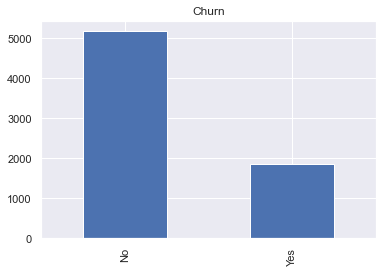

In [127]:
print(df.churn.value_counts())
df['churn'].value_counts().plot(kind='bar').set_title('Churn')

In [128]:
df.shape

(7043, 48)

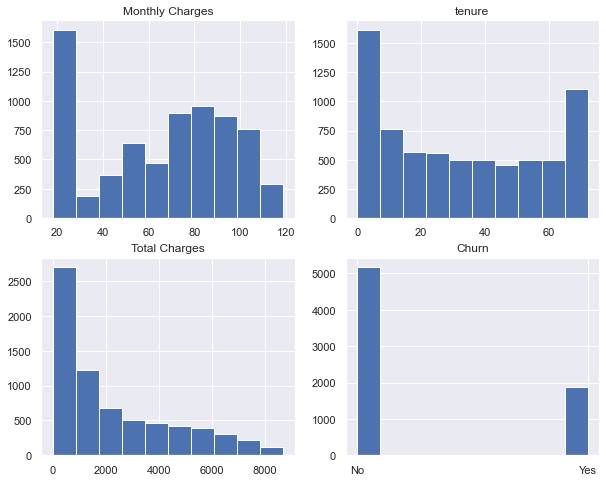

In [129]:

_, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
plt.subplot(221)
plt.hist(df.monthly_charges)
plt.title('Monthly Charges')

plt.subplot(222)
plt.hist(df.tenure)
plt.title('tenure')

plt.subplot(223)
plt.hist(df.total_charges)
plt.title('Total Charges')

plt.subplot(224)
plt.hist(df.churn)
plt.title('Churn')

plt.show()


In [130]:
# split data calling split function from prepare module.
train, validate, test=train_validate_test_split(df, target='churn')
print(train.shape)
print(validate.shape)
print(test.shape)

(4507, 48)
(1127, 48)
(1409, 48)


#### Exploration within the train dataset

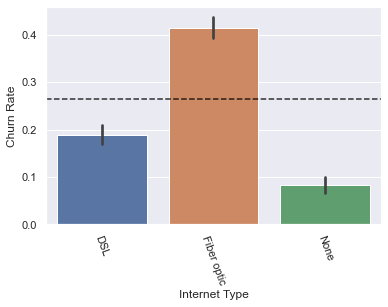

In [131]:
#
churn_rate = train['churn_encoded'].mean()

fig = sns.barplot(x= 'internet_service_type', y='churn_encoded', data=train)

fig.set(ylabel='Churn Rate')
fig.set(xlabel='Internet Type')
plt.axhline(churn_rate, ls='--', color='black', alpha =0.8)
plt.xticks(rotation=-70)
plt.show()

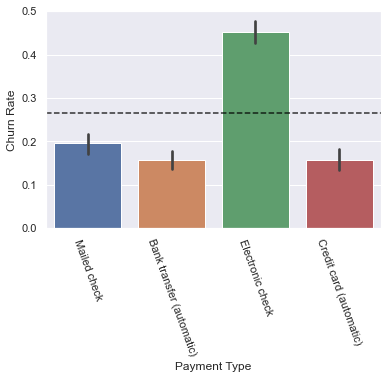

In [132]:
fig = sns.barplot(x= 'payment_type', y='churn_encoded', data=train)
fig.set(ylabel='Churn Rate')
fig.set(xlabel='Payment Type')
plt.axhline(churn_rate, ls='--', color='black', alpha =0.8)
plt.xticks(rotation=-70)
plt.show()

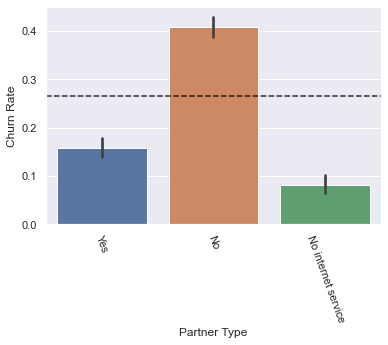

In [133]:
fig = sns.barplot(x= 'tech_support', y='churn_encoded', data=train)
fig.set(ylabel='Churn Rate')
fig.set(xlabel='Partner Type')
plt.axhline(churn_rate, ls='--', color='black', alpha =0.8)
plt.xticks(rotation=-70)
plt.show()

In [152]:
df.dtypes

customer_id                               object
gender                                    object
senior_citizen                             int64
partner                                   object
dependents                                object
tenure                                     int64
phone_service                             object
multiple_lines                            object
online_security                           object
online_backup                             object
device_protection                         object
tech_support                              object
streaming_tv                              object
streaming_movies                          object
paperless_billing                         object
monthly_charges                          float64
total_charges                            float64
churn                                     object
contract_type                             object
internet_service_type                     object
payment_type        

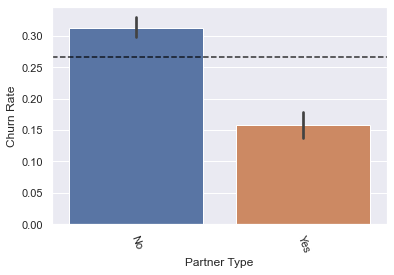

In [134]:
fig = sns.barplot(x= 'dependents', y='churn_encoded', data=train)
fig.set(ylabel='Churn Rate')
fig.set(xlabel='Partner Type')
plt.axhline(churn_rate, ls='--', color='black', alpha =0.8)
plt.xticks(rotation=-70)
plt.show()

In [157]:
features = ['phone_service','multiple_lines','partner','dependents','online_backup','online_security','device_protection','streamin_tv','streaming_movies','paperless_billings']
enumerate(features)
list(enumerate(features))

[(0, 'phone_service'),
 (1, 'multiple_lines'),
 (2, 'partner'),
 (3, 'dependents'),
 (4, 'online_backup'),
 (5, 'online_security'),
 (6, 'device_protection'),
 (7, 'streamin_tv'),
 (8, 'streaming_movies'),
 (9, 'paperless_billings')]

In [159]:
churn_rate= train.churn_encoded.mean()
_, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 10), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'churn_encoded', data=train, ax=ax[i], alpha=0.5)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn rate')
    ax[i].set_title(feature)
    ax[i].axhline(churn_rate, ls='--', color='grey')

<AxesSubplot:xlabel='tech_support', ylabel='count'>

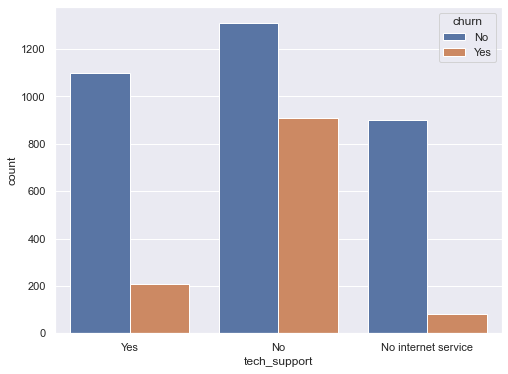

In [58]:
# 1.4. TechSupport vs Churn Relationship Analysis 
sns.set(style="darkgrid")
sns.color_palette("dark:salmon_r", as_cmap=True)
plt.figure(figsize=(8,6))
sns.countplot(x="tech_support", hue="churn", data=train)


<function matplotlib.pyplot.show(close=None, block=None)>

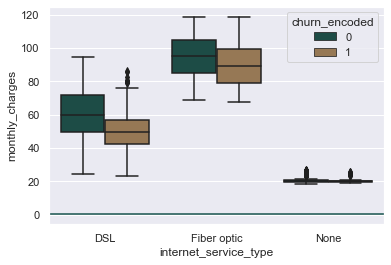

In [48]:
sns.boxplot(x='internet_service_type',y='monthly_charges',data= train, hue='churn_encoded')
mean_churn_rate = train.churn_encoded.mean()
plt.axhline(mean_churn_rate)
plt.show

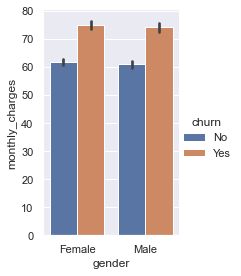

In [162]:
sns.catplot(x="gender", y="monthly_charges",
...                 hue="churn",
...                 data=df, kind="bar",
...                 height=4, aspect=.7);

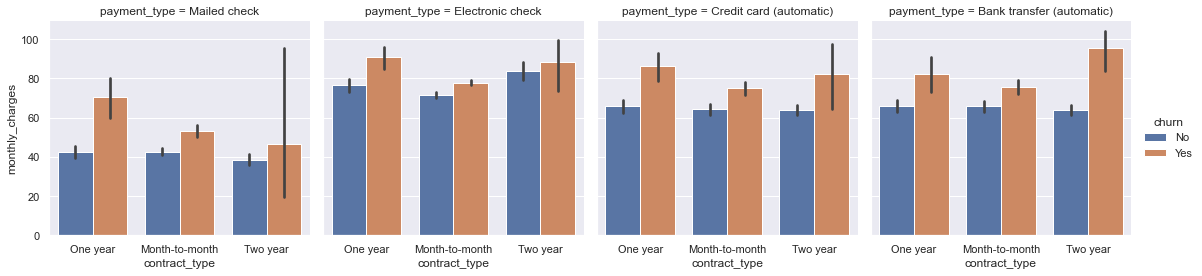

In [170]:
sns.catplot(x='contract_type', y='monthly_charges', hue='churn',col='payment_type' ,data=df,kind='bar',height=4)

<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

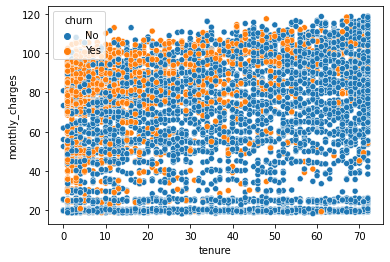

In [21]:
sns.scatterplot(x='tenure', y='monthly_charges',hue ='churn' ,data=df)